## Deploy Models for Serverless Inference

1. [Introduction](#Introduction)
2. [Prerequisites](#Prerequisites)
3. [Setup](#Setup)
4. [Deploy pretrained model to Serverless Endpoint](#Deploy-pretrained-model-to-Serverless-Endpoint)
    1. [Model Config](#Model-Config)
    2. [Serverless Deploy Config](#Serverless-Deploy-Config)
    3. [Serverless Deployment](#Serverless-Deployment)
5. [Run Inference on Serverless Endpoint](#Run-Inference-on-Serverless-Endpoint)
    1. [Create Predictor from Serverless Inference Endpoint](#Create-Predictor-from-Serverless-Inference-Endpoint)
    2. [Get trained Classes Info](#Get-trained-Classes-Info)
    3. [Download sample test images from S3 for inference](#Download-sample-test-images-from-S3-for-inference)
    4. [Get Predictions from local images](#Get-Predictions-from-local-images)
6. [Clean Up](#Clean-Up)

# Introduction
Amazon SageMaker Serverless Inference is a new inference option that enables you to easily deploy machine learning models for inference without having to configure or manage the underlying infrastructure. Simply select the serverless option when deploying your machine learning model, and Amazon SageMaker automatically provisions, scales, and turns off compute capacity based on the volume of inference requests. With SageMaker Serverless Inference, you pay only for the duration of running the inference code and the amount of data processed, not for idle time. For more information on how Serverless Inference works visit [here](https://docs.aws.amazon.com/sagemaker/latest/dg/serverless-endpoints.html). 

** Note: This Notebook was tested on Data Science Kernel for SageMaker Studio**

## Prerequisites

To run this notebook, you can simply execute each cell in order. To understand what's happening, you'll need:

- Prepare our model for deployment (either use the model from the previous modules or run the optional-prepare-data-and-model.ipynb notebook to create a new model)
- Familiarity with Python and numpy
- Basic familiarity with AWS S3.
- Basic understanding of AWS Sagemaker.
- Basic familiarity with AWS Command Line Interface (CLI) -- ideally, you should have it set up with credentials to access the AWS account you're running this notebook from.
- SageMaker Studio is preferred for the full UI integration

## Setup

Setting up the environment, load the libraries, and define the parameters for the entire notebook.

Run the cell below if you are missing smexperiments or Tensorflow in your kernel

In [2]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import botocore
import json

role = get_execution_role()
sess = sagemaker.Session()
region = boto3.Session().region_name

# S3 bucket and folders for saving model artifacts.
# Feel free to specify different bucket/folders here if you wish.
bucket = sess.default_bucket()
prefix = "BIRD-Sagemaker-Deployment"
compilation_output_sub_folder = prefix + "/compilation-output"

# S3 Location to save the model artifact after compilation
s3_compilation_output_location = "s3://{}/{}".format(bucket, compilation_output_sub_folder)
s3_compilation_output_location

TF_FRAMEWORK_VERSION = '2.4.1'

## Deploy pretrained model to Serverless Endpoint

### Model Config

You can use the bird model use created from the previous modules or run the `optional-prepare-data-and-model.ipynb` notebook to create a new model. Update the path to your model below as necessary.

In [3]:
bird_model_path = '<S3 LOCATION OF YOUR MODEL ARTIFACTS>'

### Serverless Deploy Config

You can use the bird model use created from the previous modules or run the `optional-prepare-data-and-model.ipynb` notebook to create a new model. Update the path to your model below if necessary.

In [4]:
import sagemaker.serverless as Serverless

serverless_inf_config = Serverless.ServerlessInferenceConfig(memory_size_in_mb=4096, max_concurrency=5)

### Serverless Deployment

You can use the bird model use created from the previous modules or run the `optional-prepare-data-and-model.ipynb` notebook to create a new model. Update the path to your model below if necessary.

In [5]:
from sagemaker.tensorflow import TensorFlowModel

model = TensorFlowModel(
    model_data=bird_model_path, 
    role=role,
    framework_version=TF_FRAMEWORK_VERSION)


predictor = model.deploy(serverless_inference_config=serverless_inf_config)
tf_endpoint_name = str(predictor.endpoint_name)
print(f"Endpoint [{predictor.endpoint_name}] deployed")

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----!Endpoint [tensorflow-inference-2022-05-30-21-35-56-708] deployed


The endpoint name will be displayed in the previous cell output when it's active and can also be seen under the SageMaker Resources option which is on the left side bar of the Studio as well.

![Active Endpoint](statics/active-sagemaker-endpoints.png)

## Run Inference on Serverless Endpoint

### Create Predictor from Serverless Inference Endpoint

After the deployment is complete in the above step, capture the endpoint name from SageMaker console and input below in the Predictor config. We could have reused the predictor from above step that is returned after deploy is complete, but this section shows how you can create a predictor from an existing endpoint for inference.

In [7]:
from sagemaker import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

#Update the below variable with your endpoint name from previous cell output
tf_endpoint_name='<SAGEMAKER DEPLOYED ENDPOINT NAME>'

serializer = IdentitySerializer(content_type="application/x-image")
deserializer = JSONDeserializer(accept='application/json')

predictor = Predictor(endpoint_name=tf_endpoint_name,serializer = serializer,deserializer = deserializer )

### Get trained Classes Info

In [9]:
import cv_utils

classes_file = f"s3://{bucket}/{prefix}/full/data/classes.txt"
classes = [13, 17, 35, 36, 47, 68, 73, 87]

possible_classes= cv_utils.get_classes_as_list(classes_file,classes)

possible_classes

['013.Bobolink',
 '017.Cardinal',
 '035.Purple_Finch',
 '036.Northern_Flicker',
 '047.American_Goldfinch',
 '068.Ruby_throated_Hummingbird',
 '073.Blue_Jay',
 '087.Mallard']

### Download sample test images from S3 for inference

This cell downloads a random number of images (specified by value of 'n') from 'test' data set and use them for running inferences using our model.

In [11]:
sample_images = cv_utils.get_n_random_images(bucket,prefix=f'{prefix}/outputs/test',n=2)

local_paths = cv_utils.download_images_locally(bucket,sample_images)
print(local_paths)

['./inference-test-data/American_Goldfinch_0046_32105.jpg', './inference-test-data/Mallard_0035_77095.jpg']


### Get Predictions from local images

./inference-test-data/American_Goldfinch_0046_32105.jpg


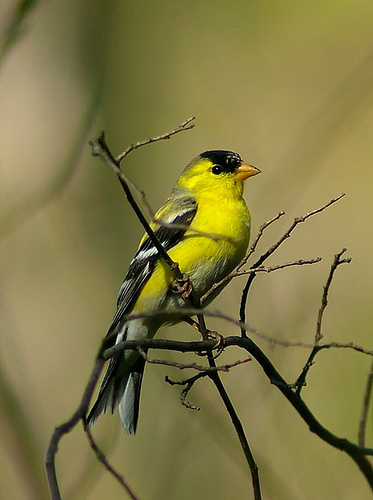

Class: 047.American_Goldfinch, confidence: 1.00
./inference-test-data/Mallard_0035_77095.jpg


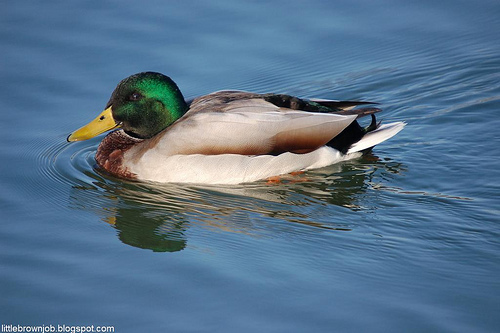

Class: 087.Mallard, confidence: 1.00


In [12]:
for inputfile in local_paths:
    print(inputfile)
    cv_utils.predict_bird_from_file(inputfile,predictor,possible_classes)

## Clean Up